In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from functions import *
from itertools import count
import gymnasium as gym
import numpy as np
from stable_baselines3 import PPO, A2C, DQN, SAC
from stable_baselines3.ppo.policies import MlpPolicy
from stable_baselines3.common.base_class import BaseAlgorithm
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise

In [30]:
# Game Setup
buyer_strategies = ['Honest', 'Random', 'Random']
seller_strategies = ['Random', 'Random', 'Random']
nbuyers, nsellers = len(buyer_strategies), len(seller_strategies)
nrounds, nperiods, ntokens, nsteps, gametype, nbuyers, nsellers = 2, 2, 10, 30, '1236', len(buyer_strategies), len(seller_strategies)
R1, R2, R3, R4 = gametype_to_ran(gametype)
game_metadata = [nrounds, nperiods, ntokens, nbuyers, nsellers, nsteps, R1, R2, R3, R4]
db = Database(game_metadata, buyer_strategies, seller_strategies)
rnd = 0
period = 0
db.reset_round(rnd, ntokens, nbuyers, nsellers, R1, R2, R3, R4)
num_actions = 51 # discrete
num_states = nsteps
min_frac = 0.01
max_frac = 1.5

In [31]:
# Create environment
class TradingEnv(gym.Env):
    def __init__(self, db, nsteps, render_mode = None):
        self.rnd = 0
        self.period = -1
        self.nperiods = nperiods
        self.db = db
        self.action_space = spaces.Box(0,1,(1,),dtype=np.float)
        self.observation_space = spaces.Box(-1,200,(13,),dtype=np.float32)

    def reset(self,seed=None):
        #self.db.reset_round(rnd, ntokens, nbuyers, nsellers, R1, R2, R3, R4)
        self.db.reset_period(self.rnd)
        self.timestep = 0
        self.period += 1
        self.db.buyers[0].next_token()
        agent = self.db.buyers[0]
        observation = np.array([0,-1,-1,-1,-1,-1,-1,-1,agent.value,-1,-1,-1,agent.num_tokens_traded], dtype = np.float32)
        return observation, {}

    def step(self, action, seed=None, options=None):
        [buyer.next_token() for buyer in self.db.buyers]
        [seller.next_token() for seller in self.db.sellers]
        bid_frac = action.item()
        # convert action to bid
        self.db.buyers[0].next_token()
        min_bid = self.db.buyers[0].value * min_frac
        max_bid = self.db.buyers[0].value * max_frac
        bid = np.round(max_bid * bid_frac + (1 - bid_frac) * min_bid, 2)

        # simulate market
        bids = [buyer.bid(self.db) for buyer in self.db.buyers]
        bids[0] = bid
        asks = [seller.ask(self.db) for seller in self.db.sellers]
        current_ask, current_ask_idx, current_bid, current_bid_idx = current_bid_ask(bids, asks)
        sale, price, bprofit, sprofit, buy, sell = buy_sell(self.db, current_bid, current_bid_idx, current_ask, current_ask_idx)
        step_data = [self.rnd, self.period, self.timestep, bids, asks, current_bid, current_bid_idx, current_ask, current_ask_idx, buy, sell, price, sale, bprofit, sprofit]
        self.db.add_step(step_data)

        # compute reward, new state
        reward = 0.0
        if sale == 1 and current_bid_idx == 0:
            reward = bprofit
            
        agent = self.db.buyers[0]
        observation = np.array([self.timestep + 1, current_ask, current_ask_idx, current_bid, current_bid_idx,
                                sale, price, buy, sell, agent.value, agent.step_profit,
                                agent.sale, agent.num_tokens_traded],dtype = np.float32)
        idx = np.isnan(observation)
        observation[idx] = -1.0
        # check termination
        self.timestep += 1
        if self.timestep == nsteps:
            terminated = True
            self.timestep = 0
        else:
            terminated = False
        infos = {"TimeLimit.truncated":True}
        truncated = False
        return observation, reward, terminated, truncated, infos

In [32]:
# Check environment
from stable_baselines3.common.env_checker import check_env
db = Database(game_metadata, buyer_strategies, seller_strategies)
db.reset_round(rnd, ntokens, nbuyers, nsellers, R1, R2, R3, R4)
env = TradingEnv(db, nsteps)
check_env(env)

AssertionError: The observation returned by the `reset()` method does not match the bounds of the given observation space Box(-1.0, 200.0, (13,), float32). 
1 invalid indices: 
Expected: -1.0 <= obs[8] <= 200.0, actual value: 670.7999877929688 


In [33]:
# Random play
rnd = 0
db = Database(game_metadata, buyer_strategies, seller_strategies)
db.reset_round(rnd, ntokens, nbuyers, nsellers, R1, R2, R3, R4)
env = TradingEnv(db, nsteps)
observation, info = env.reset()
for period in count():
    for timestep in count(): 
        action = env.action_space.sample()
        observation, reward, done, info, _ = env.step(action)
        print(f"Rnd: {rnd}, Period: {period}, New State: {observation}, Action:{np.round(action,1)}, Reward: {np.round(reward,1)}, Period End: {done}")
        if done:
            # If the episode is done, reset the environment
            #print('done')
            observation, info = env.reset()
            break
    if period == nperiods:
        period = 0
        break
env.close()

Rnd: 0, Period: 0, New State: [  1.    18.4    1.   481.5    1.     1.   249.95   1.     1.   510.8
   0.     1.     0.  ], Action:[0.2], Reward: 0.0, Period End: False
Rnd: 0, Period: 0, New State: [  2.    60.1    1.   435.2    2.     1.   247.65   1.     1.   510.8
   0.     1.     0.  ], Action:[0.1], Reward: 0.0, Period End: False
Rnd: 0, Period: 0, New State: [  3.     47.      0.    694.09    0.      1.    370.545   1.      1.
 510.8   140.255   1.      1.   ], Action:[0.9], Reward: 140.3, Period End: False
Rnd: 0, Period: 0, New State: [  4.     77.      0.    442.6     2.      1.    259.8     1.      1.
 232.4   140.255   1.      1.   ], Action:[0.4], Reward: 0.0, Period End: False
Rnd: 0, Period: 0, New State: [  5.    105.9     0.    623.1     1.      1.    364.5     1.      1.
 232.4   140.255   1.      1.   ], Action:[0.3], Reward: 0.0, Period End: False
Rnd: 0, Period: 0, New State: [  6.    115.4     0.    345.      1.      1.    230.2     1.      1.
 232.4   140.255   1

Rnd: 0, Period: 2, New State: [  7.    130.7     1.    433.7     2.      1.    282.2     1.      1.
 232.4   247.155   1.      1.   ], Action:[0.9], Reward: 0.0, Period End: False
Rnd: 0, Period: 2, New State: [  8.    141.1     2.    350.4     1.      1.    245.75    1.      1.
 232.4   247.155   1.      1.   ], Action:[0.7], Reward: 0.0, Period End: False
Rnd: 0, Period: 2, New State: [  9.    187.6     1.    278.9     2.      1.    233.25    1.      1.
 232.4   247.155   1.      1.   ], Action:[0.6], Reward: 0.0, Period End: False
Rnd: 0, Period: 2, New State: [ 10.    259.4     2.    270.8     2.      1.    265.1     1.      1.
 232.4   247.155   1.      1.   ], Action:[0.1], Reward: 0.0, Period End: False
Rnd: 0, Period: 2, New State: [ 11.    325.8     0.    231.6     2.      1.    325.8     1.      0.
 232.4   247.155   1.      1.   ], Action:[0.6], Reward: 0.0, Period End: False
Rnd: 0, Period: 2, New State: [ 12.    287.2     2.    242.91    0.      0.     -1.      0.      0.


In [110]:
rnd, period = 0,0
def graph_period(db, rnd, period):
    period_bids = list(db.get_period(rnd, period).bids)
    period_asks = list(db.get_period(rnd, period).asks)
    period_prices = list(db.get_period(rnd, period).price)
    period_sales = np.cumsum(np.where(db.get_period(rnd, period).price > 0,1,0))
    [_, demand_schedule, supply_schedule, P_grid, redemption_values, token_costs, p_eqbm, q_eqbm] = db.get_round(rnd).iloc[0].tolist()
    graph(demand_schedule, supply_schedule, P_grid, p_eqbm, q_eqbm, period_bids, period_asks, period_prices, period_sales, redemption_values, token_costs, db.ntokens, db.nbuyers, db.nsellers, db.nsteps)
    
def compute_demand_supply(redemption_values,token_costs,nbuyers,ntokens,granularity=100):
    max_price = np.max(redemption_values)
    min_price = np.min(token_costs)
    P_grid = np.linspace(min_price,max_price,granularity)
    demand_schedule = np.zeros((granularity),dtype = 'int')
    supply_schedule = np.zeros((granularity), dtype = 'int')
    for i, p in enumerate(P_grid):
        demand_schedule[i] = np.sum(p<=redemption_values)  
        supply_schedule[i] = np.sum(p>=token_costs) 
    return demand_schedule, supply_schedule, P_grid, min_price, max_price

def equilibrium(demand_schedule,supply_schedule,P_grid):
    p_eqbm, q_eqbm = [], np.nan
    for i, p in enumerate(P_grid):
        if demand_schedule[i] == supply_schedule[i]: # when sellers are ready to sell
            p_eqbm.append(p)
            q_eqbm = demand_schedule[i] 
    return np.nanmean(p_eqbm), q_eqbm


def graph(demand_schedule, supply_schedule, P_grid, p_eqbm, q_eqbm, 
                        period_bids, period_asks, period_prices, period_sales, 
                        redemption_values, token_costs, ntokens, nbuyers, nsellers, nsteps):
    minprc, maxprc = np.array(period_bids).max(), np.array(period_bids).min()
    plt.plot(demand_schedule, P_grid, label = 'Demand Curve', color = 'black', linestyle='--')
    plt.plot(supply_schedule, P_grid, label = 'Supply Curve', color = 'black', linestyle='--')
    #plt.scatter(period_prices, color='green', linestyle='--', label='Mean Real Prices')
    plt.axhline(y=np.nanmean(p_eqbm), color='black', linestyle='--', label='Mean Eqbm Prices')
    prices = []
    for i in range(nsteps):
        if (period_prices[i] > 0):
            plt.scatter([period_sales[i]]*len(period_bids[i]), period_bids[i], s = 10, marker = 'x', c = 'red')
            plt.scatter([period_sales[i]]*len(period_asks[i]), period_asks[i], s = 10, marker = 'o', c = 'blue')
        else:
            pass  
    plt.legend()
    text_content = f'q*={q_eqbm}, mean(q)={np.round(np.nanmax(period_sales),1)},p*={np.round(p_eqbm,1)}, mean(p)={np.round(np.nanmean(period_prices),1)}'
    plt.title(text_content)
    plt.xlim(0,q_eqbm+2)
    plt.ylim(minprc, maxprc)
    plt.show()
    
    plt.plot(np.array(period_bids)[:,0], c = 'o', linestyle='--')
    plt.plot(np.array(period_bids)[:,1:], c = 'r', linestyle='--')
    plt.plot(np.array(period_asks), c = 'b', linestyle='--')
    plt.scatter(range(nsteps), period_prices, c = 'g')
    plt.title('Bids (red), Asks (blue) and Prices (green) over trading steps')
    plt.show()

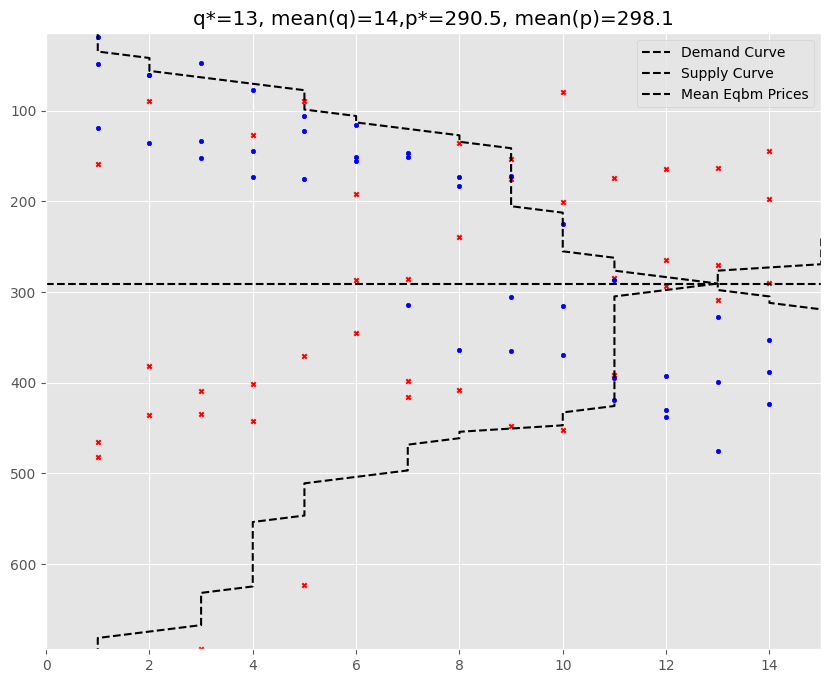

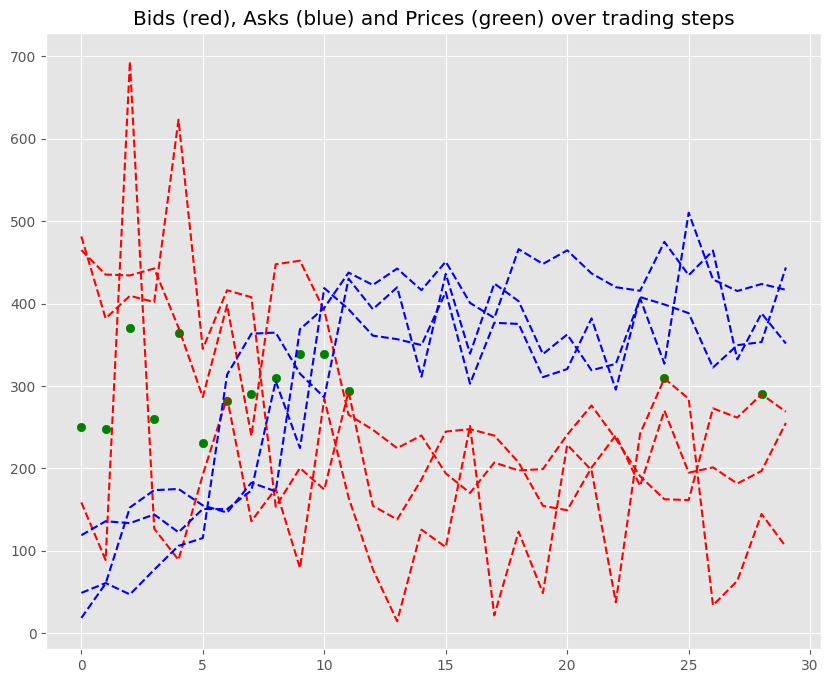

In [111]:
graph_period(db, rnd, period)

In [125]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib notebook 

def graph(demand_schedule, supply_schedule, P_grid, p_eqbm, q_eqbm,
          period_bids, period_asks, period_prices, period_sales,
          redemption_values, token_costs, ntokens, nbuyers, nsellers, nsteps):
    
    minprc, maxprc = np.array(period_bids).max(), np.array(period_bids).min()
    
    
    plt.plot(demand_schedule, P_grid, label='Demand Curve', color='black', linestyle='--')
    plt.plot(supply_schedule, P_grid, label='Supply Curve', color='black', linestyle='--')
    plt.axhline(y=np.nanmean(p_eqbm), color='black', linestyle='--', label='Mean Eqbm Prices')
    
    prices = []
    for i in range(nsteps):
        if (period_prices[i] > 0):
            # Clear the previous plot
            plt.clf()
            
            # Plot the demand and supply curves
            plt.plot(demand_schedule, P_grid, label='Demand Curve', color='black', linestyle='--')
            plt.plot(supply_schedule, P_grid, label='Supply Curve', color='black', linestyle='--')
            plt.axhline(y=np.nanmean(p_eqbm), color='black', linestyle='--', label='Mean Eqbm Prices')
            
            # Overlay the bids and asks for the current period
            plt.scatter([period_sales[i]] * len(period_bids[i]), period_bids[i], s=10, marker='x', c='red', label='Bids')
            plt.scatter([period_sales[i]] * len(period_asks[i]), period_asks[i], s=10, marker='o', c='blue', label='Asks')
            
            plt.xlabel('Quantity')
            plt.ylabel('Price')
            plt.legend()
            text_content = f'q*={q_eqbm}, mean(q)={np.round(np.nanmax(period_sales), 1)},p*={np.round(p_eqbm, 1)}, mean(p)={np.round(np.nanmean(period_prices), 1)}'
            plt.title(text_content)
            plt.xlim(0, q_eqbm + 2)
            plt.ylim(minprc, maxprc)
            plt.grid(True)
            
            plt.show()  # Show the updated plot
        else:
            pass
    plt.show()


<IPython.core.display.Javascript object>


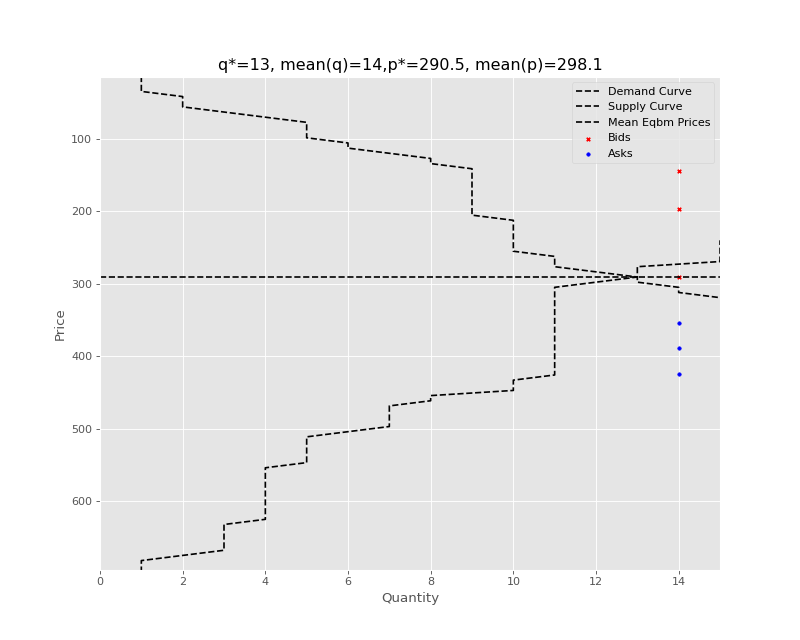

In [126]:
graph_period(db, rnd, period)

In [127]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, widgets

def plot_order_book(demand_schedule, supply_schedule, P_grid, p_eqbm, q_eqbm,
                    period_bids, period_asks, period_prices, period_sales,
                    redemption_values, token_costs, ntokens, nbuyers, nsellers, nsteps, step):
    minprc, maxprc = np.array(period_bids).max(), np.array(period_bids).min()
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(demand_schedule, P_grid, label='Demand Curve', color='black', linestyle='--')
    plt.plot(supply_schedule, P_grid, label='Supply Curve', color='black', linestyle='--')
    plt.axhline(y=np.nanmean(p_eqbm), color='black', linestyle='--', label='Mean Eqbm Prices')
    
    i = step - 1
    if (period_prices[i] > 0):
        # Plot the demand and supply curves
        plt.plot(demand_schedule, P_grid, label='Demand Curve', color='black', linestyle='--')
        plt.plot(supply_schedule, P_grid, label='Supply Curve', color='black', linestyle='--')
        plt.axhline(y=np.nanmean(p_eqbm), color='black', linestyle='--', label='Mean Eqbm Prices')
        
        # Overlay the bids and asks for the current period
        plt.scatter([period_sales[i]] * len(period_bids[i]), period_bids[i], s=10, marker='x', c='red', label='Bids')
        plt.scatter([period_sales[i]] * len(period_asks[i]), period_asks[i], s=10, marker='o', c='blue', label='Asks')
        
        plt.xlabel('Quantity')
        plt.ylabel('Price')
        plt.legend()
        text_content = f'q*={q_eqbm}, mean(q)={np.round(np.nanmax(period_sales), 1)},p*={np.round(p_eqbm, 1)}, mean(p)={np.round(np.nanmean(period_prices), 1)}'
        plt.title(text_content)
        plt.xlim(0, q_eqbm + 2)
        plt.ylim(minprc, maxprc)
        plt.grid(True)
        plt.show()

def interactive_order_book(demand_schedule, supply_schedule, P_grid, p_eqbm, q_eqbm,
                           period_bids, period_asks, period_prices, period_sales,
                           redemption_values, token_costs, ntokens, nbuyers, nsellers, nsteps):
    step_slider = widgets.IntSlider(min=1, max=nsteps, step=1, value=1, description='Step:')
    interact(plot_order_book,
             demand_schedule=widgets.fixed(demand_schedule),
             supply_schedule=widgets.fixed(supply_schedule),
             P_grid=widgets.fixed(P_grid),
             p_eqbm=widgets.fixed(p_eqbm),
             q_eqbm=widgets.fixed(q_eqbm),
             period_bids=widgets.fixed(period_bids),
             period_asks=widgets.fixed(period_asks),
             period_prices=widgets.fixed(period_prices),
             period_sales=widgets.fixed(period_sales),
             redemption_values=widgets.fixed(redemption_values),
             token_costs=widgets.fixed(token_costs),
             ntokens=widgets.fixed(ntokens),
             nbuyers=widgets.fixed(nbuyers),
             nsellers=widgets.fixed(nsellers),
             nsteps=widgets.fixed(nsteps),
             step=step_slider)

# Example data
demand_schedule = [100, 90, 80, 70, 60]
supply_schedule = [40, 50, 60, 70, 80]
P_grid = [10, 20, 30, 40, 50]
p_eqbm = 25
q_eqbm = 45
period_bids = [[10, 9, 8, 7, 6], [11, 10, 9, 8, 7]]
period_asks = [[12, 13, 14, 15, 16], [11, 12, 13, 14, 15]]
period_prices = [22, 28]
period_sales = [45, 45]
redemption_values = [5, 5]
token_costs = [2, 2]
ntokens = 100
nbuyers = 20
nsellers = 20
nsteps = 2

interactive_order_book(demand_schedule, supply_schedule, P_grid, p_eqbm, q_eqbm,
                       period_bids, period_asks, period_prices, period_sales,
                       redemption_values, token_costs, ntokens, nbuyers, nsellers, nsteps)


interactive(children=(IntSlider(value=1, description='Step:', max=2, min=1), Output()), _dom_classes=('widget-…

In [129]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

def graph(demand_schedule, supply_schedule, P_grid, p_eqbm, q_eqbm,
          period_bids, period_asks, period_prices, period_sales,
          redemption_values, token_costs, ntokens, nbuyers, nsellers, nsteps):
    
    # Create a figure for order book visualization
    fig_order_book = go.Figure()
    
    # Plot demand and supply curves
    fig_order_book.add_trace(go.Scatter(x=demand_schedule, y=P_grid, mode='lines', name='Demand Curve', line=dict(dash='dash')))
    fig_order_book.add_trace(go.Scatter(x=supply_schedule, y=P_grid, mode='lines', name='Supply Curve', line=dict(dash='dash')))
    fig_order_book.add_shape(dict(type='line', x0=0, x1=q_eqbm, y0=p_eqbm, y1=p_eqbm, line=dict(dash='dash'), name='Mean Eqbm Prices'))

    for i in range(nsteps):
        if (period_prices[i] > 0):
            # Overlay bids and asks for the current period
            fig_order_book.add_trace(go.Scatter(x=[period_sales[i]] * len(period_bids[i]), y=period_bids[i], 
                                                mode='markers', marker=dict(symbol='x', size=8, color='red'), name='Bids'))
            fig_order_book.add_trace(go.Scatter(x=[period_sales[i]] * len(period_asks[i]), y=period_asks[i], 
                                                mode='markers', marker=dict(symbol='circle', size=8, color='blue'), name='Asks'))
    
    # Configure layout for the order book visualization
    fig_order_book.update_layout(
        title=f'q*={q_eqbm}, mean(q)={np.round(np.nanmax(period_sales), 1)}, p*={np.round(p_eqbm, 1)}, mean(p)={np.round(np.nanmean(period_prices), 1)}',
        xaxis_title='Quantity',
        yaxis_title='Price',
        xaxis=dict(range=[0, q_eqbm + 2]),
        yaxis=dict(range=[min(P_grid), max(P_grid)]),
        legend=dict(x=0.02, y=0.95),
        showlegend=True
    )
    
    # Create a figure for trading steps visualization
    fig_trading_steps = go.Figure()

    fig_trading_steps.add_trace(go.Scatter(x=list(range(nsteps)), y=period_bids, mode='lines', name='Bids', line=dict(dash='dash')))
    fig_trading_steps.add_trace(go.Scatter(x=list(range(nsteps)), y=period_asks, mode='lines', name='Asks', line=dict(dash='dash')))
    fig_trading_steps.add_trace(go.Scatter(x=list(range(nsteps)), y=period_prices, mode='markers', name='Prices', marker=dict(size=8, color='green')))

    # Configure layout for the trading steps visualization
    fig_trading_steps.update_layout(
        title='Bids (red), Asks (blue), and Prices (green) over Trading Steps',
        xaxis_title='Trading Steps',
        yaxis_title='Price',
        xaxis=dict(tickvals=list(range(nsteps))),
        legend=dict(x=0.02, y=0.95),
        showlegend=True,
        grid=True
    )
    
    # Show the order book and trading steps figures
    fig_order_book.show()
    fig_trading_steps.show()

# Example data
demand_schedule = [100, 90, 80, 70, 60]
supply_schedule = [40, 50, 60, 70, 80]
P_grid = [10, 20, 30, 40, 50]
p_eqbm = 25
q_eqbm = 45
period_bids = [[10, 9, 8, 7, 6], [11, 10, 9, 8, 7]]
period_asks = [[12, 13, 14, 15, 16], [11, 12, 13, 14, 15]]
period_prices = [22, 28]
period_sales = [45, 45]
redemption_values = [5, 5]
token_costs = [2, 2]
ntokens = 100
nbuyers = 20
nsellers = 20
nsteps = 2

graph(demand_schedule, supply_schedule, P_grid, p_eqbm, q_eqbm,
      period_bids, period_asks, period_prices, period_sales,
      redemption_values, token_costs, ntokens, nbuyers, nsellers, nsteps)


ValueError: 
    Invalid value of type 'builtins.bool' received for the 'grid' property of layout
        Received value: True

    The 'grid' property is an instance of Grid
    that may be specified as:
      - An instance of :class:`plotly.graph_objs.layout.Grid`
      - A dict of string/value properties that will be passed
        to the Grid constructor

        Supported dict properties:
            
            columns
                The number of columns in the grid. If you
                provide a 2D `subplots` array, the length of
                its longest row is used as the default. If you
                give an `xaxes` array, its length is used as
                the default. But it's also possible to have a
                different length, if you want to leave a row at
                the end for non-cartesian subplots.
            domain
                :class:`plotly.graph_objects.layout.grid.Domain
                ` instance or dict with compatible properties
            pattern
                If no `subplots`, `xaxes`, or `yaxes` are given
                but we do have `rows` and `columns`, we can
                generate defaults using consecutive axis IDs,
                in two ways: "coupled" gives one x axis per
                column and one y axis per row. "independent"
                uses a new xy pair for each cell, left-to-right
                across each row then iterating rows according
                to `roworder`.
            roworder
                Is the first row the top or the bottom? Note
                that columns are always enumerated from left to
                right.
            rows
                The number of rows in the grid. If you provide
                a 2D `subplots` array or a `yaxes` array, its
                length is used as the default. But it's also
                possible to have a different length, if you
                want to leave a row at the end for non-
                cartesian subplots.
            subplots
                Used for freeform grids, where some axes may be
                shared across subplots but others are not. Each
                entry should be a cartesian subplot id, like
                "xy" or "x3y2", or "" to leave that cell empty.
                You may reuse x axes within the same column,
                and y axes within the same row. Non-cartesian
                subplots and traces that support `domain` can
                place themselves in this grid separately using
                the `gridcell` attribute.
            xaxes
                Used with `yaxes` when the x and y axes are
                shared across columns and rows. Each entry
                should be an x axis id like "x", "x2", etc., or
                "" to not put an x axis in that column. Entries
                other than "" must be unique. Ignored if
                `subplots` is present. If missing but `yaxes`
                is present, will generate consecutive IDs.
            xgap
                Horizontal space between grid cells, expressed
                as a fraction of the total width available to
                one cell. Defaults to 0.1 for coupled-axes
                grids and 0.2 for independent grids.
            xside
                Sets where the x axis labels and titles go.
                "bottom" means the very bottom of the grid.
                "bottom plot" is the lowest plot that each x
                axis is used in. "top" and "top plot" are
                similar.
            yaxes
                Used with `yaxes` when the x and y axes are
                shared across columns and rows. Each entry
                should be an y axis id like "y", "y2", etc., or
                "" to not put a y axis in that row. Entries
                other than "" must be unique. Ignored if
                `subplots` is present. If missing but `xaxes`
                is present, will generate consecutive IDs.
            ygap
                Vertical space between grid cells, expressed as
                a fraction of the total height available to one
                cell. Defaults to 0.1 for coupled-axes grids
                and 0.3 for independent grids.
            yside
                Sets where the y axis labels and titles go.
                "left" means the very left edge of the grid.
                *left plot* is the leftmost plot that each y
                axis is used in. "right" and *right plot* are
                similar.


<IPython.core.display.Javascript object>


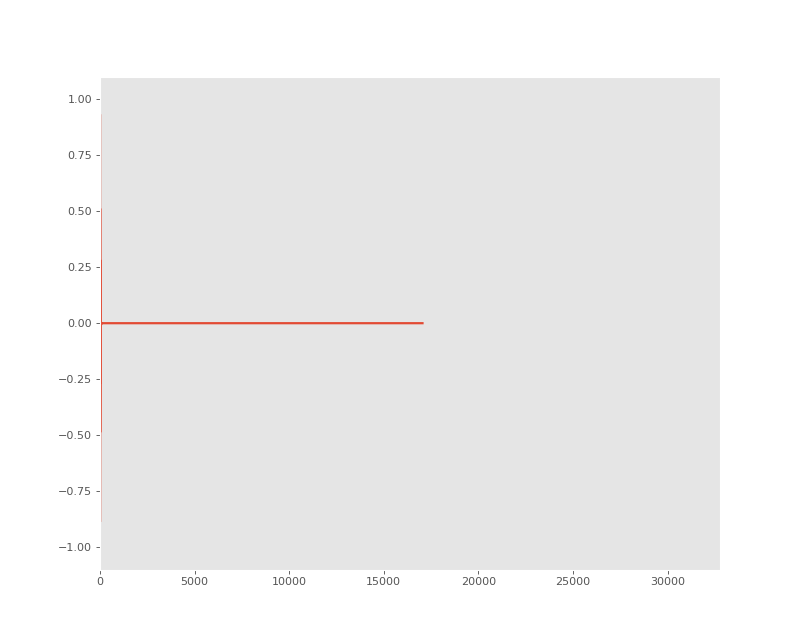

In [131]:
import itertools

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation


def data_gen():
    for cnt in itertools.count():
        t = cnt / 10
        yield t, np.sin(2*np.pi*t) * np.exp(-t/10.)


def init():
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlim(0, 1)
    del xdata[:]
    del ydata[:]
    line.set_data(xdata, ydata)
    return line,

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.grid()
xdata, ydata = [], []


def run(data):
    # update the data
    t, y = data
    xdata.append(t)
    ydata.append(y)
    xmin, xmax = ax.get_xlim()

    if t >= xmax:
        ax.set_xlim(xmin, 2*xmax)
        ax.figure.canvas.draw()
    line.set_data(xdata, ydata)

    return line,

# Only save last 100 frames, but run forever
ani = animation.FuncAnimation(fig, run, data_gen, interval=100, init_func=init,
                              save_count=100)
plt.show()

In [8]:
# Training parameters
rnd = 0
period = 0
num_states = nsteps
min_frac = 0.01
max_frac = 1.5
eval_steps = 1000
training_step = 50000

### Continous Action Space

In [9]:
from stable_baselines3 import SAC, DDPG, TD3, A2C, PPO
db = Database(game_metadata, buyer_strategies, seller_strategies)
db.reset_round(rnd, ntokens, nbuyers, nsellers, R1, R2, R3, R4)
env = TradingEnv(db, nsteps)
n_actions = env.action_space.shape[-1]
param_noise = None
action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5) * np.ones(n_actions))
policy_kwargs = dict(net_arch=dict(pi=[128, 128], qf=[128, 128]))
model = SAC("Ln MlpPolicy", env, policy_kwargs=policy_kwargs, verbose=1, batch_size=128, action_noise = action_noise)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
model.learn(50000, progress_bar = True)

Output()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 154      |
| time/              |          |
|    episodes        | 4        |
|    fps             | 80       |
|    time_elapsed    | 2        |
|    total_timesteps | 200      |
| train/             |          |
|    actor_loss      | -4.91    |
|    critic_loss     | 51.7     |
|    ent_coef        | 0.991    |
|    ent_coef_loss   | -0.0147  |
|    learning_rate   | 0.0003   |
|    n_updates       | 99       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 166      |
| time/              |          |
|    episodes        | 8        |
|    fps             | 63       |
|    time_elapsed    | 6        |
|    total_timesteps | 400      |
| train/             |          |
|    actor_loss      | -8.31    |
|    critic_loss     | 39.7     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 143      |
| time/              |          |
|    episodes        | 64       |
|    fps             | 50       |
|    time_elapsed    | 63       |
|    total_timesteps | 3200     |
| train/             |          |
|    actor_loss      | -22.8    |
|    critic_loss     | 47.2     |
|    ent_coef        | 0.433    |
|    ent_coef_loss   | -1.04    |
|    learning_rate   | 0.0003   |
|    n_updates       | 3099     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 145      |
| time/              |          |
|    episodes        | 68       |
|    fps             | 50       |
|    time_elapsed    | 67       |
|    total_timesteps | 3400     |
| train/             |          |
|    actor_loss      | -14.3    |
|    critic_loss     | 15.7     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 153      |
| time/              |          |
|    episodes        | 124      |
|    fps             | 51       |
|    time_elapsed    | 119      |
|    total_timesteps | 6200     |
| train/             |          |
|    actor_loss      | -19.5    |
|    critic_loss     | 16.1     |
|    ent_coef        | 0.178    |
|    ent_coef_loss   | -2.19    |
|    learning_rate   | 0.0003   |
|    n_updates       | 6099     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 154      |
| time/              |          |
|    episodes        | 128      |
|    fps             | 51       |
|    time_elapsed    | 123      |
|    total_timesteps | 6400     |
| train/             |          |
|    actor_loss      | -19      |
|    critic_loss     | 19.1     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 169      |
| time/              |          |
|    episodes        | 184      |
|    fps             | 50       |
|    time_elapsed    | 183      |
|    total_timesteps | 9200     |
| train/             |          |
|    actor_loss      | -24.9    |
|    critic_loss     | 19.1     |
|    ent_coef        | 0.0855   |
|    ent_coef_loss   | -1.82    |
|    learning_rate   | 0.0003   |
|    n_updates       | 9099     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 170      |
| time/              |          |
|    episodes        | 188      |
|    fps             | 50       |
|    time_elapsed    | 187      |
|    total_timesteps | 9400     |
| train/             |          |
|    actor_loss      | -29.1    |
|    critic_loss     | 15.7     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 182      |
| time/              |          |
|    episodes        | 244      |
|    fps             | 48       |
|    time_elapsed    | 254      |
|    total_timesteps | 12200    |
| train/             |          |
|    actor_loss      | -35.9    |
|    critic_loss     | 15       |
|    ent_coef        | 0.0458   |
|    ent_coef_loss   | -1.09    |
|    learning_rate   | 0.0003   |
|    n_updates       | 12099    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 183      |
| time/              |          |
|    episodes        | 248      |
|    fps             | 47       |
|    time_elapsed    | 262      |
|    total_timesteps | 12400    |
| train/             |          |
|    actor_loss      | -35.8    |
|    critic_loss     | 14.1     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 199      |
| time/              |          |
|    episodes        | 308      |
|    fps             | 45       |
|    time_elapsed    | 337      |
|    total_timesteps | 15400    |
| train/             |          |
|    actor_loss      | -35.6    |
|    critic_loss     | 16.9     |
|    ent_coef        | 0.0357   |
|    ent_coef_loss   | -0.297   |
|    learning_rate   | 0.0003   |
|    n_updates       | 15299    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 201      |
| time/              |          |
|    episodes        | 312      |
|    fps             | 45       |
|    time_elapsed    | 342      |
|    total_timesteps | 15600    |
| train/             |          |
|    actor_loss      | -43      |
|    critic_loss     | 14.8     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 221      |
| time/              |          |
|    episodes        | 368      |
|    fps             | 44       |
|    time_elapsed    | 414      |
|    total_timesteps | 18400    |
| train/             |          |
|    actor_loss      | -46.4    |
|    critic_loss     | 14.9     |
|    ent_coef        | 0.0329   |
|    ent_coef_loss   | -0.25    |
|    learning_rate   | 0.0003   |
|    n_updates       | 18299    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 222      |
| time/              |          |
|    episodes        | 372      |
|    fps             | 44       |
|    time_elapsed    | 419      |
|    total_timesteps | 18600    |
| train/             |          |
|    actor_loss      | -45.3    |
|    critic_loss     | 19.9     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 248      |
| time/              |          |
|    episodes        | 428      |
|    fps             | 44       |
|    time_elapsed    | 485      |
|    total_timesteps | 21400    |
| train/             |          |
|    actor_loss      | -43.2    |
|    critic_loss     | 13.7     |
|    ent_coef        | 0.0259   |
|    ent_coef_loss   | -0.454   |
|    learning_rate   | 0.0003   |
|    n_updates       | 21299    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 249      |
| time/              |          |
|    episodes        | 432      |
|    fps             | 43       |
|    time_elapsed    | 491      |
|    total_timesteps | 21600    |
| train/             |          |
|    actor_loss      | -50.6    |
|    critic_loss     | 17.4     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 270      |
| time/              |          |
|    episodes        | 488      |
|    fps             | 43       |
|    time_elapsed    | 560      |
|    total_timesteps | 24400    |
| train/             |          |
|    actor_loss      | -53.6    |
|    critic_loss     | 12.6     |
|    ent_coef        | 0.0417   |
|    ent_coef_loss   | 0.623    |
|    learning_rate   | 0.0003   |
|    n_updates       | 24299    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 270      |
| time/              |          |
|    episodes        | 492      |
|    fps             | 43       |
|    time_elapsed    | 566      |
|    total_timesteps | 24600    |
| train/             |          |
|    actor_loss      | -51.8    |
|    critic_loss     | 13.2     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 274      |
| time/              |          |
|    episodes        | 548      |
|    fps             | 42       |
|    time_elapsed    | 637      |
|    total_timesteps | 27400    |
| train/             |          |
|    actor_loss      | -69.4    |
|    critic_loss     | 14.4     |
|    ent_coef        | 0.0747   |
|    ent_coef_loss   | 0.432    |
|    learning_rate   | 0.0003   |
|    n_updates       | 27299    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 274      |
| time/              |          |
|    episodes        | 552      |
|    fps             | 42       |
|    time_elapsed    | 642      |
|    total_timesteps | 27600    |
| train/             |          |
|    actor_loss      | -58      |
|    critic_loss     | 14.2     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 268      |
| time/              |          |
|    episodes        | 612      |
|    fps             | 42       |
|    time_elapsed    | 720      |
|    total_timesteps | 30600    |
| train/             |          |
|    actor_loss      | -70.8    |
|    critic_loss     | 8.59     |
|    ent_coef        | 0.0956   |
|    ent_coef_loss   | -0.525   |
|    learning_rate   | 0.0003   |
|    n_updates       | 30499    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 268      |
| time/              |          |
|    episodes        | 616      |
|    fps             | 42       |
|    time_elapsed    | 724      |
|    total_timesteps | 30800    |
| train/             |          |
|    actor_loss      | -73.5    |
|    critic_loss     | 7.04     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 274      |
| time/              |          |
|    episodes        | 672      |
|    fps             | 42       |
|    time_elapsed    | 792      |
|    total_timesteps | 33600    |
| train/             |          |
|    actor_loss      | -84.5    |
|    critic_loss     | 7.03     |
|    ent_coef        | 0.0954   |
|    ent_coef_loss   | -0.156   |
|    learning_rate   | 0.0003   |
|    n_updates       | 33499    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 276      |
| time/              |          |
|    episodes        | 680      |
|    fps             | 42       |
|    time_elapsed    | 802      |
|    total_timesteps | 34000    |
| train/             |          |
|    actor_loss      | -86.1    |
|    critic_loss     | 8.45     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 277      |
| time/              |          |
|    episodes        | 736      |
|    fps             | 42       |
|    time_elapsed    | 876      |
|    total_timesteps | 36800    |
| train/             |          |
|    actor_loss      | -83      |
|    critic_loss     | 4.41     |
|    ent_coef        | 0.104    |
|    ent_coef_loss   | -0.266   |
|    learning_rate   | 0.0003   |
|    n_updates       | 36699    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 278      |
| time/              |          |
|    episodes        | 740      |
|    fps             | 41       |
|    time_elapsed    | 882      |
|    total_timesteps | 37000    |
| train/             |          |
|    actor_loss      | -92.5    |
|    critic_loss     | 5.35     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 276      |
| time/              |          |
|    episodes        | 796      |
|    fps             | 40       |
|    time_elapsed    | 988      |
|    total_timesteps | 39800    |
| train/             |          |
|    actor_loss      | -92.8    |
|    critic_loss     | 5.78     |
|    ent_coef        | 0.109    |
|    ent_coef_loss   | 0.239    |
|    learning_rate   | 0.0003   |
|    n_updates       | 39699    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 277      |
| time/              |          |
|    episodes        | 800      |
|    fps             | 40       |
|    time_elapsed    | 999      |
|    total_timesteps | 40000    |
| train/             |          |
|    actor_loss      | -90.8    |
|    critic_loss     | 5.73     |
|    ent_coef 

In [19]:
db.step_data.head(500).groupby('current_bid_idx').sum()

,rnd,period,step,current_bid,current_ask,current_ask_idx,buy,sell,price,sale,bprofit,sprofit
current_bid_idx,,,,,,,,,,,,
0,0,490,2668,7168.89,4443.3,589,60,90,4857.39,91,92.41,1807.99
1,0,329,1176,4361.80,2628.6,339,69,67,3417.30,70,1511.70,1133.10
2,0,607,4170,5947.30,5853.7,669,39,41,2094.10,44,903.10,705.40
3,0,435,2171,5084.70,3547.3,521,60,57,2934.50,60,1529.50,1237.20
4,0,389,2065,4796.40,3285.7,430,47,47,2458.35,49,1449.05,1144.75


In [20]:
db.step_data.tail(500).groupby('current_bid_idx').sum()

,rnd,period,step,current_bid,current_ask,current_ask_idx,buy,sell,price,sale,bprofit,sprofit
current_bid_idx,,,,,,,,,,,,
0,0,56744,1313,2922.51,2446.3,313,52,42,2238.795,52,1106.005,489.295
1,0,67593,1092,4623.70,2564.2,337,70,70,3403.800,70,1525.200,1352.400
2,0,133295,4630,6540.90,6400.7,795,48,45,2342.500,50,921.000,787.300
3,0,98225,2616,5727.20,4157.8,621,60,60,2964.950,60,1499.050,1282.950
4,0,94603,2599,5276.10,4033.6,545,48,46,2438.500,50,1513.500,1165.600


In [ ]:
db.round_data.redemption_values.item()

In [ ]:
db.step_data.tail(60)

In [ ]:
graph_period(env.db, 0, 2236)

In [ ]:
from stable_baselines3 import DQN
db = Database(game_metadata, buyer_strategies, seller_strategies)
db.reset_round(rnd, ntokens, nbuyers, nsellers, R1, R2, R3, R4)
env = TradingEnv(db, nsteps)
env.action_space = spaces.Discrete(51)
#policy_kwargs = dict(net_arch=dict(pi=[64, 64], qf=[64, 64]))
model = DQN("MlpPolicy", env, verbose=1,)
model.learn(50000, progress_bar = False)

In [ ]:
db.step_data.head(100).groupby('current_bid_idx').sum()

In [ ]:
db.step_data.tail(100).groupby('current_bid_idx').sum()

## ON POLICY

### DDPG - Deterministic Deep Policy Gradient

In [ ]:
from stable_baselines3 import DDPG
db = Database(game_metadata, buyer_strategies, seller_strategies)
db.reset_round(rnd, ntokens, nbuyers, nsellers, R1, R2, R3, R4)
env = TradingEnv(db, nsteps)
policy_kwargs = dict(net_arch=dict(pi=[64, 64], qf=[64, 64]))
model = DDPG("MlpPolicy", env, policy_kwargs=policy_kwargs, verbose=1,)
model.learn(50000, progress_bar = True)

In [17]:
db.step_data.head(100).groupby('current_bid_idx').sum()

,rnd,period,step,current_bid,current_ask,current_ask_idx,buy,sell,price,sale,bprofit,sprofit
current_bid_idx,,,,,,,,,,,,
0,0,11,562,1433.54,914.6,109,12,19,1014.965,19,2.835,352.065
1,0,7,214,874.80,478.2,68,14,14,676.500,14,309.300,251.200
2,0,12,855,1262.00,1241.7,159,8,8,429.400,9,178.600,159.800
3,0,13,492,1080.60,774.7,118,12,11,600.700,12,292.100,257.900
4,0,7,327,839.20,572.6,67,10,10,498.950,10,291.450,195.850


In [18]:
db.step_data.tail(100).groupby('current_bid_idx').sum()

,rnd,period,step,current_bid,current_ask,current_ask_idx,buy,sell,price,sale,bprofit,sprofit
current_bid_idx,,,,,,,,,,,,
0,0,10857,269,506.15,514.1,73,10,6,432.865,10,162.835,56.565
1,0,13579,239,946.20,548.3,44,14,14,709.250,14,276.550,278.950
2,0,26237,899,1291.80,1228.7,169,11,9,505.900,11,197.900,146.000
3,0,22625,586,1247.20,936.0,142,13,13,609.450,13,335.850,278.750
4,0,17194,457,1009.10,693.3,105,9,10,488.600,10,301.800,258.100


### PPO - Proximal Policy Optimization

In [ ]:
from stable_baselines3 import PPO
db = Database(game_metadata, buyer_strategies, seller_strategies)
db.reset_round(rnd, ntokens, nbuyers, nsellers, R1, R2, R3, R4)
env = TradingEnv(db, nsteps)
policy_kwargs = dict(net_arch=dict(pi=[64, 64], qf=[64, 64]))
model = PPO("MlpPolicy", env, policy_kwargs=policy_kwargs, verbose=1)
model.learn(50000, progress_bar = False)

### A2C - Advantage Actor-Critic

In [ ]:
# Create A2C model
from stable_baselines3.ppo.policies import MlpPolicy
a2c_model = A2C(MlpPolicy, env, verbose=0)

# Train the A2C agent for 10000 steps
a2c_model.learn(total_timesteps=training_step, progress_bar = True)

# Evaluate the trained A2C agent
mean_reward_a2c, std_reward_a2c = evaluate_policy(a2c_model, env, n_eval_episodes=eval_steps)
print(f"A2C mean_reward: {mean_reward_a2c:.2f} +/- {std_reward_a2c:.2f}")